# HMetaD Within-Subjects (Repeated Measures) Tutorial

This notebook demonstrates the hierarchical Bayesian (HB) within-subjects HMeta-d
model using two conditions (easy vs hard). We simulate 100 trials per condition
per subject, fit the repeated-measures model, and compare posterior m-ratio
(Mratio = meta-d'/d') between conditions.

Quick run recipe:
```bash
conda create -n metadpy-demo python=3.11 -y
conda activate metadpy-demo
pip install "git+https://github.com/heyifei1984/metadpy.git@main"
pip install jupyter matplotlib arviz ipykernel
python -m ipykernel install --user --name metadpy-demo
jupyter lab
```


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

import metadpy
from metadpy.bayesian import hmetad
from metadpy.utils import pairedResponseSimulation


In [2]:
print('metadpy version:', metadpy.__version__)


metadpy version: 0.1.1


## Simulate two conditions (within-subjects)

We simulate two conditions for each subject:
- easy: higher Mratio
- hard: lower Mratio

Each subject has 100 trials per condition and 4 confidence ratings.


In [3]:
np.random.seed(123)

n_subjects = 50
n_trials = 100
n_ratings = 4

mratio_easy = 1.6
mratio_hard = 0.3

sim_df = pairedResponseSimulation(
    d=1.5,
    d_sigma=0.0,
    mRatio=[mratio_easy, mratio_hard],
    mRatio_sigma=0.05,
    mRatio_rho=0.6,
    c=0.0,
    c_sigma=0.0,
    nRatings=n_ratings,
    nTrials=n_trials,
    nSubjects=n_subjects,
)

sim_df['Condition'] = sim_df['Condition'].map({0: 'easy', 1: 'hard'})

sim_df.head()


,Stimuli,Responses,Accuracy,Confidence,nTrial,Subject,Condition
0,0,0,1,4,0,0,easy
1,1,1,1,4,1,0,easy
2,1,1,1,3,2,0,easy
3,1,1,1,4,3,0,easy
4,1,1,1,2,4,0,easy


In [4]:
sim_df.groupby(['Subject', 'Condition']).size().unstack().head()


Condition,easy,hard
Subject,,
0,100,100
1,100,100
2,100,100
3,100,100
4,100,100


## Fit the HB within-subjects HMeta-d model

We fit the repeated-measures model by providing both `subject` and `within`.


In [5]:
model, idata = hmetad(
    data=sim_df,
    nRatings=n_ratings,
    stimuli='Stimuli',
    accuracy='Accuracy',
    confidence='Confidence',
    subject='Subject',
    within='Condition',
    num_samples=300,
    num_chains=2,
    random_seed=123,
)


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu_d1, sigma_d1, d1, mu_c1, sigma_c1, c1, mu_meta_d, sigma_meta_d, condition_offset_raw, meta_d, cS1_hn, cS2_hn]


Sampling 2 chains for 1_000 tune and 300 draw iterations (2_000 + 600 draws total) took 197 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


## Posterior summaries and condition difference

We compute Mratio per subject and condition, then summarize the group-level
posterior for each condition and their difference (hard - easy).


In [6]:
meta_d = idata.posterior['meta_d']
d1 = idata.posterior['d1']

dims = {dim: size for dim, size in meta_d.sizes.items() if dim not in ('chain', 'draw')}
subj_dim = max(dims, key=dims.get)
cond_dim = min(dims, key=dims.get)

m_ratio = meta_d / d1
m_ratio = m_ratio.assign_coords({cond_dim: ['easy', 'hard']})
m_ratio_mean = m_ratio.mean(dim=subj_dim)

mratio_easy_post = m_ratio_mean.sel({cond_dim: 'easy'})
mratio_hard_post = m_ratio_mean.sel({cond_dim: 'hard'})

delta = mratio_hard_post - mratio_easy_post

delta_vals = np.asarray(delta.values).reshape(-1)
prob_hard_lower = float((delta_vals < 0).mean())
hdi_vals = az.hdi(delta_vals, hdi_prob=0.94)
hdi_vals = np.asarray(hdi_vals).reshape(-1)

print('P(hard < easy):', round(prob_hard_lower, 3))
print('94% HDI for delta (hard - easy):', [round(float(hdi_vals[0]), 3), round(float(hdi_vals[1]), 3)])


P(hard < easy): 1.0
94% HDI for delta (hard - easy): [-1.499, -1.201]


/Users/yifei/anaconda3/lib/python3.11/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (100) in plot_posterior, generating only 40 plots
  warnings.warn(
/Users/yifei/anaconda3/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


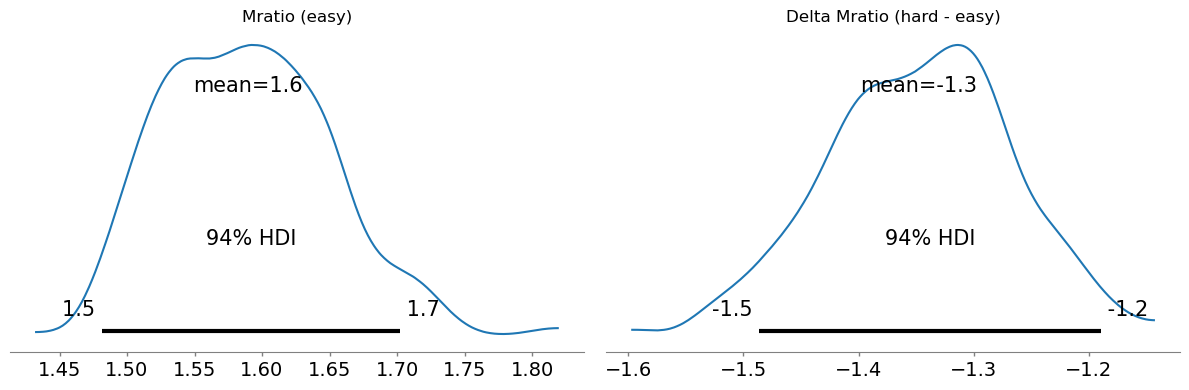

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

az.plot_posterior(mratio_easy_post, hdi_prob=0.94, ax=ax[0])
ax[0].set_title('Mratio (easy)')

az.plot_posterior(delta, hdi_prob=0.94, ax=ax[1])
ax[1].set_title('Delta Mratio (hard - easy)')

plt.tight_layout()


In [8]:
summary = az.summary(
    idata,
    var_names=['mu_meta_d', 'condition_offset', 'mu_d1', 'mu_c1'],
    round_to=3,
)
summary[['mean', 'sd', 'hdi_3%', 'hdi_97%']]


/Users/yifei/anaconda3/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%
mu_meta_d,1.416,0.041,1.350,1.509
condition_offset[0],1.043,0.048,0.956,1.138
condition_offset[1],-1.043,0.048,-1.138,-0.956
mu_d1,1.548,0.029,1.500,1.608
mu_c1,0.004,0.013,-0.022,0.029


## Conceptual consistency with Fleming (2017)

The paper describes a hierarchical Bayesian HMeta-d framework where subject-level
parameters are pooled, confidence counts are modeled with multinomials, and the
group-level distributions capture uncertainty and between-subject variability.
Our within-subjects model follows the same core structure (hierarchical pooling
plus response-conditional criteria) and extends it by adding a condition offset
term for meta-d. This aligns with the paper's note that the model can be flexibly
expanded to estimate other influences on metacognitive efficiency.
